In [1]:
import tensorflow as tf
import numpy
import matplotlib.pyplot as plt
import random
import math
import time
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("mnist/", one_hot=True)

D:\Anaconda3\envs\tfcpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [2]:
num_train=mnist.train.num_examples
num_val=mnist.validation.images.shape
num_test=mnist.test.images.shape

# Baseline: CNN

In [3]:
X=tf.placeholder(dtype=tf.float32,shape=[None,28,28,1],name='X')
y=tf.placeholder(dtype=tf.int64,shape=[None,10],name='y')
is_training=tf.placeholder(dtype=tf.bool,name='is_training')
cnn_out1=tf.layers.conv2d(X,128,kernel_size=3,strides=(1, 1),padding='same')
bn_out1=tf.layers.batch_normalization(cnn_out1,axis=3,training=is_training)
relu_out1=tf.nn.relu(bn_out1)
pool_out1=tf.layers.max_pooling2d(relu_out1,[2,2],[2,2])
cnn_out2=tf.layers.conv2d(pool_out1,128,kernel_size=3,strides=(1, 1),padding='same')
bn_out2=tf.layers.batch_normalization(cnn_out2,axis=3,training=is_training)
relu_out1=tf.nn.relu(bn_out2)
pool_out2=tf.layers.max_pooling2d(relu_out1,[2,2],[2,2])
flt=tf.layers.flatten(pool_out2)
out1=tf.layers.dense(flt,1024)
bn_out3=tf.layers.batch_normalization(out1,axis=1,training=is_training)
score=tf.layers.dense(out1,10)
predictions = tf.argmax(score, 1)
correct_predictions = tf.equal(predictions, tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"))

loss=tf.losses.softmax_cross_entropy(onehot_labels=y,logits=score)
optimizier=tf.train.AdamOptimizer(learning_rate=1e-5)
train_step = optimizier.minimize(loss)

In [4]:
max_epoch=10
batch_size=8
print_every=625

def train():
    num_iteration=num_train//batch_size
    for it in range(num_iteration):
        images,labels=mnist.train.next_batch(batch_size)
        loss_num,_ = sess.run([loss,train_step],feed_dict={X:images.reshape(-1,28,28,1),y:labels,is_training:True})
        if it==0 or (it+1)%print_every==0 or it==num_iteration-1:
            print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                  'iteration %d/%d:' % (it+1,num_iteration),'current training loss = %f' % (loss_num))
            
def eval(dataset,num_iteration):
    total_loss=0
    total_accuracy=0
    for it in range(num_iteration):
        images,labels=dataset.next_batch(batch_size)
        loss_num,accuracy_num = sess.run([loss,accuracy],feed_dict={X:images.reshape(-1,28,28,1),y:labels,is_training:False})
        total_loss+=loss_num
        total_accuracy+=accuracy_num
    total_loss/=num_iteration
    total_accuracy/=num_iteration
    return total_loss,total_accuracy
    
acc_train_his=[]
acc_val_his=[]
acc_test_his=[]
    
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(max_epoch):
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'start epoch %d/%d:' % (epoch+1,max_epoch))
        train()
        loss_train,acc_train=eval(mnist.train,2000)
        loss_val,acc_val=eval(mnist.validation,500)
        loss_test,acc_test=eval(mnist.test,1000)
        acc_train_his.append(acc_train)
        acc_val_his.append(acc_val)
        acc_test_his.append(acc_test)
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'end epoch %d/%d:' % (epoch+1,max_epoch),
             'acc_train=%.3f%% acc_val=%.3f%% acc_test=%.3f%%' % (acc_train*100.0,acc_val*100.0,acc_test*100.0))

2018-04-06 14:30:56 start epoch 1/10:
2018-04-06 14:30:57 iteration 1/6875: current training loss = 4.211929
2018-04-06 14:32:20 iteration 625/6875: current training loss = 0.087236
2018-04-06 14:33:41 iteration 1250/6875: current training loss = 0.013274
2018-04-06 14:35:03 iteration 1875/6875: current training loss = 0.114186
2018-04-06 14:36:25 iteration 2500/6875: current training loss = 0.124054
2018-04-06 14:37:46 iteration 3125/6875: current training loss = 1.019795
2018-04-06 14:39:07 iteration 3750/6875: current training loss = 0.140595
2018-04-06 14:40:28 iteration 4375/6875: current training loss = 0.040953
2018-04-06 14:41:49 iteration 5000/6875: current training loss = 0.164956
2018-04-06 14:43:10 iteration 5625/6875: current training loss = 0.031330
2018-04-06 14:44:31 iteration 6250/6875: current training loss = 0.185917
2018-04-06 14:45:53 iteration 6875/6875: current training loss = 0.032837
2018-04-06 14:47:04 end epoch 1/10: acc_train=88.331% acc_val=89.750% acc_test

2018-04-06 16:44:59 iteration 1250/6875: current training loss = 0.000421
2018-04-06 16:46:22 iteration 1875/6875: current training loss = 0.000007
2018-04-06 16:47:45 iteration 2500/6875: current training loss = 0.000002
2018-04-06 16:49:06 iteration 3125/6875: current training loss = 0.000970
2018-04-06 16:50:29 iteration 3750/6875: current training loss = 0.000000
2018-04-06 16:51:51 iteration 4375/6875: current training loss = 0.000484
2018-04-06 16:53:13 iteration 5000/6875: current training loss = 0.000086
2018-04-06 16:54:30 iteration 5625/6875: current training loss = 0.000067
2018-04-06 16:55:49 iteration 6250/6875: current training loss = 0.000005
2018-04-06 16:57:07 iteration 6875/6875: current training loss = 0.002449
2018-04-06 16:58:16 end epoch 9/10: acc_train=97.375% acc_val=97.050% acc_test=97.425%
2018-04-06 16:58:16 start epoch 10/10:
2018-04-06 16:58:16 iteration 1/6875: current training loss = 0.000223
2018-04-06 16:59:34 iteration 625/6875: current training loss =

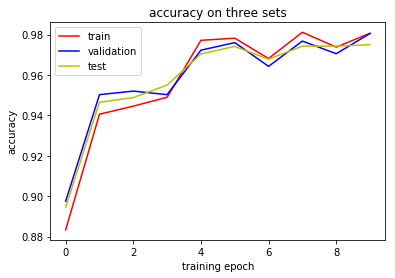

In [5]:
plt.figure(1)
ptr,=plt.plot(range(max_epoch),acc_train_his,'r-')
pva,=plt.plot(range(max_epoch),acc_val_his,'b-')
pte,=plt.plot(range(max_epoch),acc_test_his,'y-')
plt.xlabel('training epoch')
plt.ylabel('accuracy')
plt.title('accuracy on three sets')
plt.legend((ptr,pva,pte),('train','validation','test'))
plt.show()